In [101]:
#importing necessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import nltk
import re
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import contractions
from collections import defaultdict,Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import plotly
plotly.offline.init_notebook_mode(connected = True)
from plotly.offline import iplot
from textwrap import wrap
from wordcloud import WordCloud

In [102]:
#loading training data
train=pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
train.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [103]:
#loading test data
test=pd.read_csv('Corona_NLP_test.csv')
test.head()

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

In [104]:
train.shape,test.shape

((41157, 6), (3798, 6))

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [107]:
train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [108]:
test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

*Since we are only interested in tweets and sentiment removing other columns from train and test sets so the missing values will be removed from both sets.*

In [109]:
train.drop(columns=['TweetAt','UserName','ScreenName','Location'],axis=1,inplace=True)
test.drop(columns=['TweetAt','UserName','ScreenName','Location'],axis=1,inplace=True)

In [110]:
train.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [111]:
test.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [112]:
train.rename(columns={'OriginalTweet':'Tweet'},inplace=True)
test.rename(columns={'OriginalTweet':'Tweet'},inplace=True)

In [113]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [114]:
test['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

*In both train and test sets there are 5 classes instead of 3 classes i.e. Positive, Neutral and Negative.Therefore representing Extremely Positive tweets as Positive tweets and  Extremely Negative tweets as Negative tweets.*

In [115]:
train.Sentiment.replace({'Extremely Positive': 'Positive','Extremely Negative': 'Negative'},inplace=True)
test.Sentiment.replace({'Extremely Positive': 'Positive','Extremely Negative': 'Negative'},inplace=True)

In [116]:
px.pie(train,'Sentiment',title='Distribution of Sentiment in Training Data')

*Training dataset has 43.8 % of positive tweets,37.4% of the negative tweets and 18.7% of neutral tweets.*

In [117]:
px.pie(test,'Sentiment',title='Distribution of Sentiment in Test Data')

*Test dataset has 43% of negative tweets,40.7% of positive tweets and 16.3% of neutral tweets.*

***It can be seen that test dataset has more negative tweets then training dataset and less positive tweets than train dataset.However,distribution of neutral tweets is having minor difference in both sets.***

In [118]:
train=train.drop_duplicates()
test=test.drop_duplicates()

In [119]:
#function for data cleaning
def preprocessing(review_text):
    review_text=re.sub(r'http\S+',' ',review_text) #removing the url
    review_text=contractions.fix(review_text)#for removing contractions like don't,I'd 
    review_text=re.sub('[^a-z-A-Z]',' ',review_text) #removing numbers and punctuation
    review_text=re.sub('[-*]',' ',review_text)#for removing any number of hyphens
    review_text=str(review_text).lower()   #converting all characters into lowercase
    review_text=review_text.split()
    review_text=[word for word in review_text if len(word) > 1]#removing words of length 1
    review_text=[word for word in review_text if word!='amp']#removing irrelevant word 'amp' from corpus
    review_text = ' '.join(review_text)
    return review_text

In [120]:
train['Tweet']=train['Tweet'].apply(lambda x : preprocessing(x))
test['Tweet']=test['Tweet'].apply(lambda x : preprocessing(x))

In [121]:
train.head()

Tweet Sentiment
0               menyrbie phil gahan chrisitv and and   Neutral
1  advice talk to your neighbours family to excha...  Positive
2  coronavirus australia woolworths to give elder...  Positive
3  my food stock is not the only one which is emp...  Positive
4  me ready to go at supermarket during the covid...  Negative

In [122]:
test.head()

Tweet Sentiment
0  trending new yorkers encounter empty supermark...  Negative
1  when could not find hand sanitizer at fred mey...  Positive
2  find out how you can protect yourself and love...  Positive
3  panic buying hits newyork city as anxious shop...  Negative
4  toiletpaper dunnypaper coronavirus coronavirus...   Neutral

In [123]:
#function to plot histogram defining number of characters in tweets
def char_hist(dataframe):
    plt.figure(figsize=(10,5))
    dataframe['Tweet'].str.len().hist()
    plt.xticks(np.arange(0,300,20))
    plt.xlabel('Number of Characters')

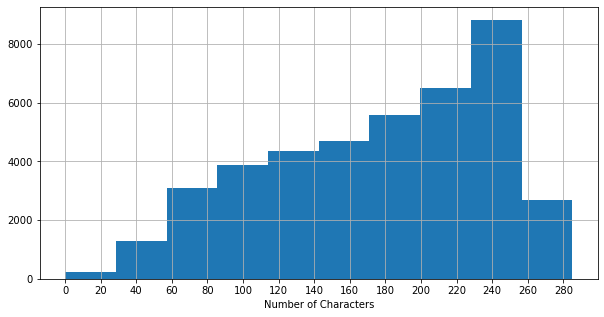

In [124]:
char_hist(train)

*It is clear that the tweets contain 0-280 characters with most of the tweets have size between 220-260 characters in training set.*

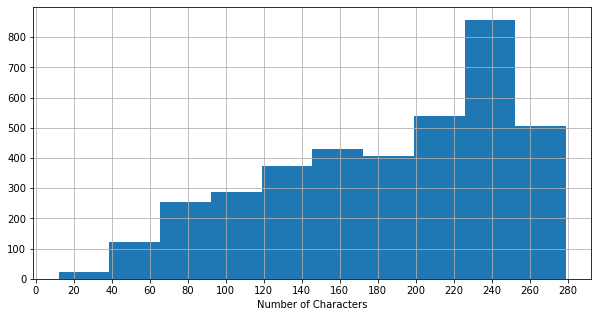

In [125]:
char_hist(test)

*It is clear that the tweets contain 20-280 characters with most of the tweets have size between 240-260 characters in test set.*

In [126]:
##function to plot histogram defining number of words in tweets
def word_hist(dataframe):
    plt.figure(figsize=(10,5))
    dataframe['Tweet'].str.split().map(lambda x:len(x)).hist()
    plt.xticks(np.arange(0,70,5))
    plt.xlabel('Number of Words')

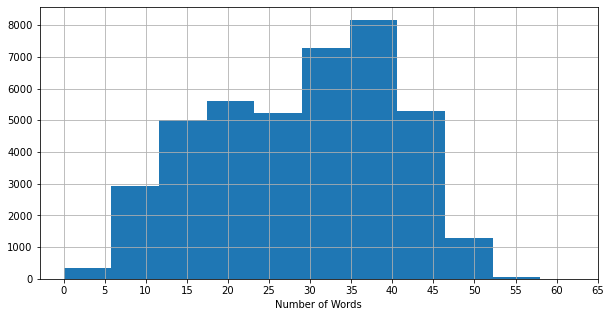

In [127]:
word_hist(train)

*It is clear that number of tweets have words between 0 to 60 with most of the tweets having 25 to 45 words in training set.*

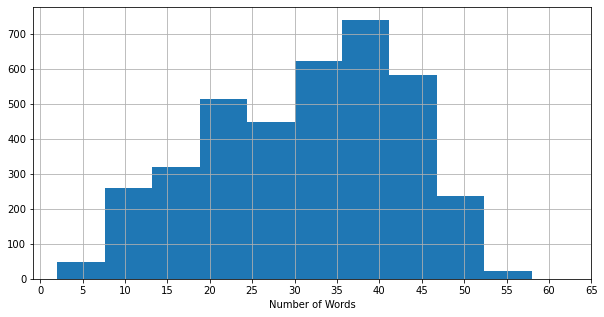

In [128]:
word_hist(test)

*It is clear that number of tweeets have 0-60 words with most of the tweets having 30 to 45 words in test set.*

In [129]:
#function to plot histogram defining average word length in tweets
def avg_word_length_hist(dataframe):
    plt.figure(figsize=(10,5))
    dataframe.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
    plt.xticks(np.arange(1,12))
    plt.xlabel('Average Word Length')

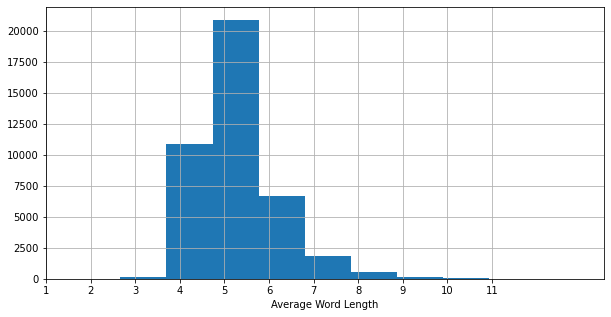

In [130]:
avg_word_length_hist(train['Tweet'])

*The average word length ranges between 3 to 11 with 5-6 being most common in training set.*

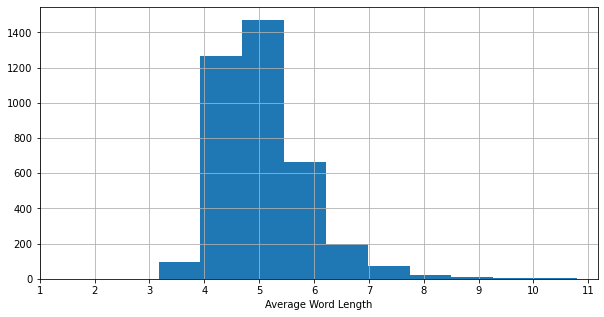

In [131]:
avg_word_length_hist(test['Tweet'])

*The average word length ranges between 3 to 11 with 4 to 6 being most common in test set.

*Does it mean that people are writing very short tweets to express their opinions?This can happen due to presence of stopwords.*

In [135]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tusha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [136]:
#function to plot bar graph containing top 10 most occuring stopwords
def stop_plot(dataframe,title):
    words=dataframe.str.split().tolist()
    corpus=[text for i in words for text in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.figure(figsize=(10,5))
    plt.bar(x,y)
    plt.xlabel(title)

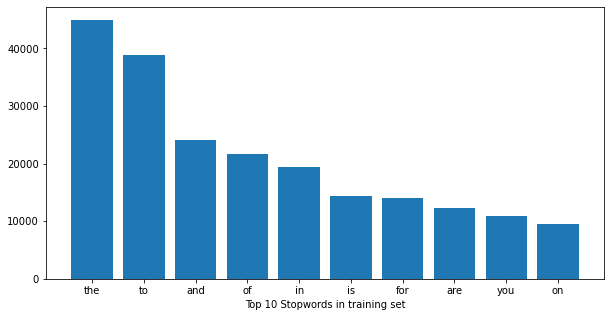

In [137]:
stop_plot(train['Tweet'],'Top 10 Stopwords in training set')

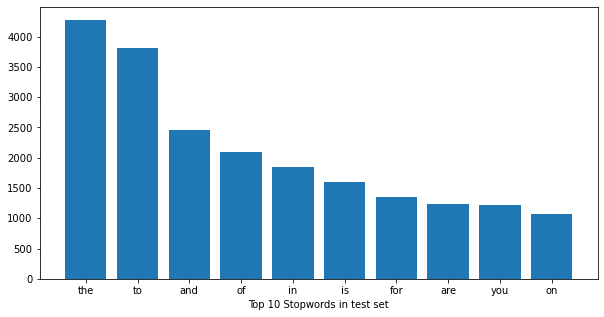

In [138]:
stop_plot(test['Tweet'],'Top 10 Stopwords in test set')

*'the','to' and 'and' are the most commonly occured out of other top 10 stopwords in training and test set.*

*Let's analyze which words other than stopwords occur most frequently in training and test sets.*

In [139]:
#function to plot bar graph containing top 10 most occuring words
def word_count_plot(dataframe,title):
    words=dataframe.str.split().tolist()
    corpus=[text for i in words for text in i]
    dic=defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word]+=1
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20] 
    x,y=zip(*top)
    plt.figure(figsize=(10,5))
    plt.barh(x,y)
    plt.xlabel(title)

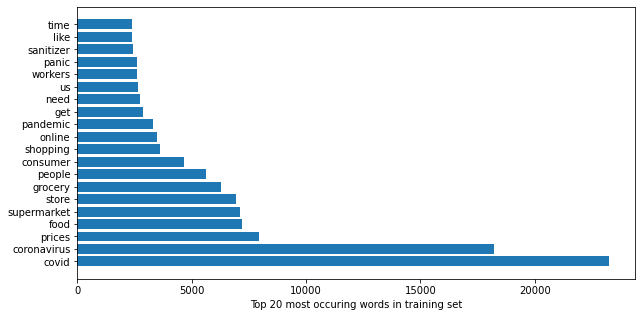

In [140]:
word_count_plot(train['Tweet'],'Top 20 most occuring words in training set')

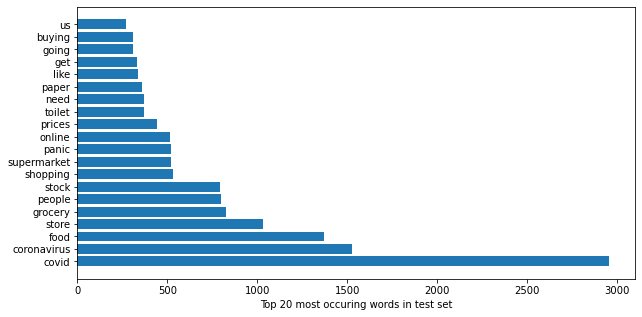

In [141]:
word_count_plot(test['Tweet'],'Top 20 most occuring words in test set')

*Words related to coronavirus like 'Covid','Coronavirus' occurs most of the times in both training and test sets.*

*Calculating senitment polarity using textblob where polarity exists in range (-1,1) where -1 stands for negative,0 stands for neutral and 1 stands for positive.*

Text(0.5, 1.0, 'Polarity Score in Training Set')

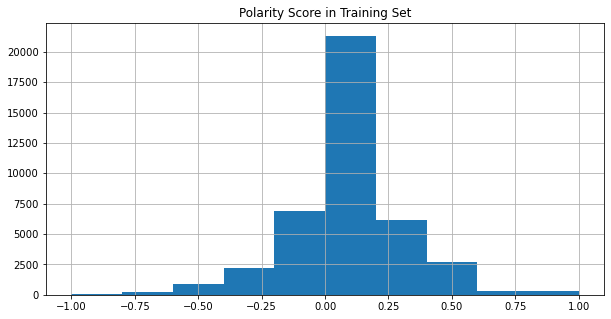

In [143]:
plt.figure(figsize=(10,5))
train['Polarity_Score'].hist()
plt.title("Polarity Score in Training Set")

Text(0.5, 1.0, 'Polarity Score in Test Set')

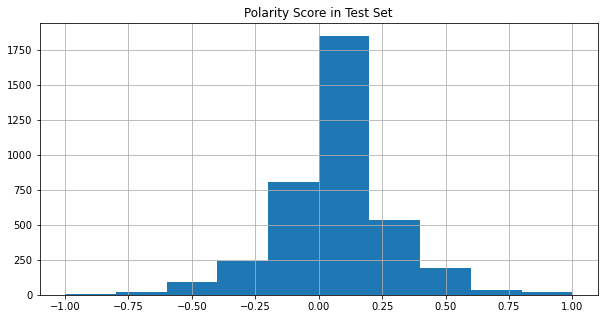

In [144]:
plt.figure(figsize=(10,5))
test['Polarity_Score'].hist()
plt.title("Polarity Score in Test Set")

*Both training and test sets have majority tweets neutral to positive in range between (0-0.5).*

In [151]:
# Loading model
nlp = spacy.load('en_core_web_sm',exclude=['parser','ner'])

# Lemmatization with stopwords removal in training set
train['train_cleaned']=train['Tweet'].\
apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
# Lemmatization with stopwords removal in test set
test['test_cleaned']=test['Tweet'].\
apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [152]:
train['Polarity_Score']=train['train_cleaned'].map(lambda text:TextBlob(text).sentiment.polarity)
test['Polarity_Score']=test['test_cleaned'].map(lambda text:TextBlob(text).sentiment.polarity)

In [159]:
print('5 random reviews with the highest positive sentiment polarity in training set: \n')
cl = train.loc[train.Polarity_Score == 1, ['train_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest positive sentiment polarity in training set: 

week decide baking find delicious plum argentina grocery store decide plum tart

start look delicious nofood coronavirus groceryshopping

shout publix grocery store guy excellent job keep shelf stock food thank employee covid coronavirus grocerystore groceryshoppe

perfect storm face hunger crisis demand food bank soar

self drive robot deliver food family street dispense hand sanitizer shanghai china effort help contain coronavirus outbreak awesome



In [160]:
print('5 random reviews with the highest positive sentiment polarity in test set: \n')
cl = test.loc[test.Polarity_Score == 1, ['test_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest positive sentiment polarity in test set: 

goldendisc purchase site take minute choose cd check superb shopping ireland online covid

amazon grocery store seattle scan amazon code phone app walk grab bag begin put item bag scanning need walk cashier self checkout line perfect isolationist amazongo coronavirus

get need dinner doesn look delicious

dear buy neil awesome image bunch job cancel covid apocalypse support online shopping

panel sid tele perfectly embody mood supermarket today corona coronaviruspandemic coronaviruspandemic covid fear supermarket grocery indiecomic dystopia dystopian panicbuying panicshoppe hoarding panicbuyer kickstarter apocalyptic



In [161]:
print('5 random reviews with the highest neutral sentiment polarity in training set: \n')
cl = train.loc[train.Polarity_Score == 0, ['train_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest neutral sentiment polarity in training set: 

feel score refried bean grocery store today

god forbid mother want buy thermometer stock goodluckwiththat coronavirus

narendramodi hello sir self harish covid effect people indian finnalcial system overcome finnalical status indian rupee value paisa increase value currency sir help purchase

covid afford online shopping

chart day gold shape bounce pm socialdistance border gold silver mining investment speculator market profit coronavirus stock china italylockdown trump borisjohnson currency wealth health



In [163]:
print('5 random reviews with the highest neutral sentiment polarity in test set: \n')
cl = test.loc[test.Polarity_Score == 0, ['test_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest neutral sentiment polarity in test set: 

supermarket situation france coronavirus covid lockdown france

grocery store ohio covid masshysteria

forestandpaper member commit safety employee end user monitor covid rest assure tissue manufacturer continue produce ship product

buy coronavirus outbreak stock pantry fridge covid

supermarket shelf nyc loo roll hoarding aussie thing aupol coronavirus covid



In [164]:
print('5 random reviews with the highest negative sentiment polarity in training set: \n')
cl = train.loc[train.Polarity_Score == -1, ['train_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest negative sentiment polarity in training set: 

trip grocery store horrible people want hour conversation extrovert covid quarantine helpmepleaseiamgoingcrazyhahahahahahahahahahahahahaaaaa

awful raise people

piersmorgan doubt ll read piersmorgan thing think disgusting asda put price remove offer item people shop store struggle mortgage holiday downgrade anyt

skyuk receive email title look customer covid receive letter today say put price find insulting

dobetter coronavirus yvr ppl disgusting yyc like bc



In [171]:
#in test set maximum negative polarity is -0.8
print('5 random reviews with the highest negative sentiment polarity in test set: \n')
cl = test.loc[test.Polarity_Score == -0.8, ['test_cleaned']].sample(5).values
for c in cl:
    print(c[0])
    print()

5 random reviews with the highest negative sentiment polarity in test set: 

bbcbreake carer uk happen people care abandon online shopping delivery slot week borisjohnson matthancock idiot

ffs covid contend idiot create shortage wake people shop restriction auspol

die covid die starvation stupid irrational idiot buy food stock non existent grandkid hell humanity coronavirus

line saturday morning cole supermarket hate think day go bring panickbuye coronavirusaustralia coronavirus covid covid australia

credit card carry apple card email offer day interest payment march help coronavirus amex visa card hate apple know care consumer



In [172]:
train.isnull().sum()

Tweet             0
Sentiment         0
Polarity_Score    0
train_cleaned     0
dtype: int64

In [173]:
test.isnull().sum()

Tweet             0
Sentiment         0
Polarity_Score    0
test_cleaned      0
dtype: int64

In [174]:
#function to calculate ngrams for both train and test dataset
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

Text(0.5, 1.0, 'Top unigrams in training set')

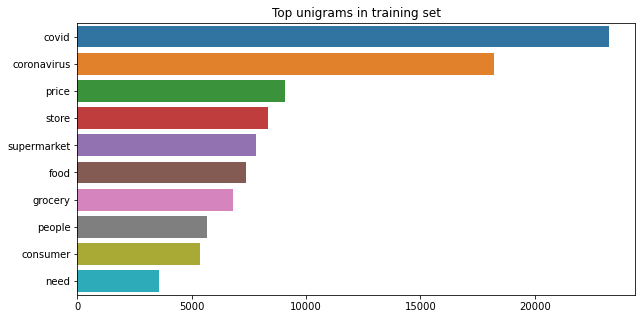

In [175]:
top_n_unigrams=get_top_ngram(train['train_cleaned'],1)
x,y=map(list,zip(*top_n_unigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top unigrams in training set')

Text(0.5, 1.0, 'Top unigrams in test set')

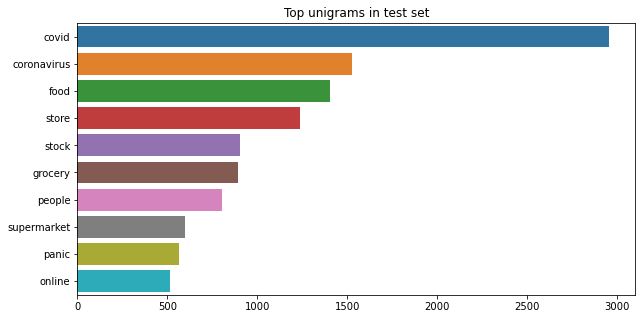

In [176]:
top_n_unigrams=get_top_ngram(test['test_cleaned'],1)
x,y=map(list,zip(*top_n_unigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top unigrams in test set')

Text(0.5, 1.0, 'Top bigrams in training set')

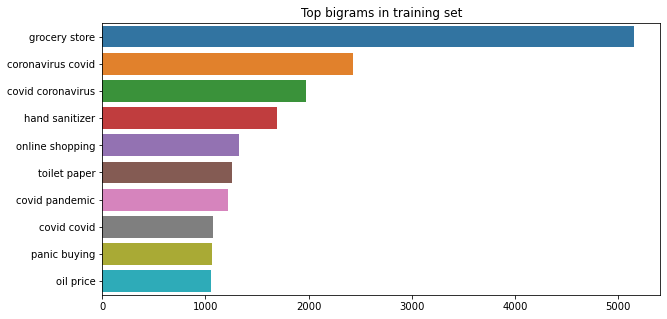

In [177]:
top_n_bigrams=get_top_ngram(train['train_cleaned'],2)
x,y=map(list,zip(*top_n_bigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top bigrams in training set')

Text(0.5, 1.0, 'Top bigrams in test set')

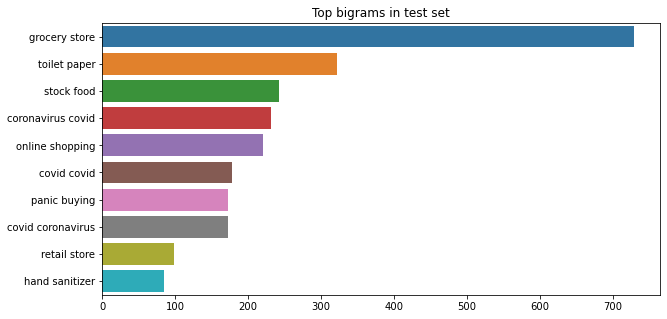

In [178]:
top_n_bigrams=get_top_ngram(test['test_cleaned'],2)
x,y=map(list,zip(*top_n_bigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top bigrams in test set')

Text(0.5, 1.0, 'Top trigrams in training set')

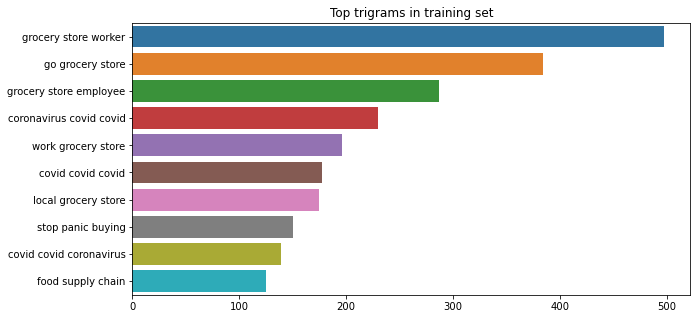

In [179]:
top_n_trigrams=get_top_ngram(train['train_cleaned'],3)
x,y=map(list,zip(*top_n_trigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top trigrams in training set')

Text(0.5, 1.0, 'Top trigrams in test set')

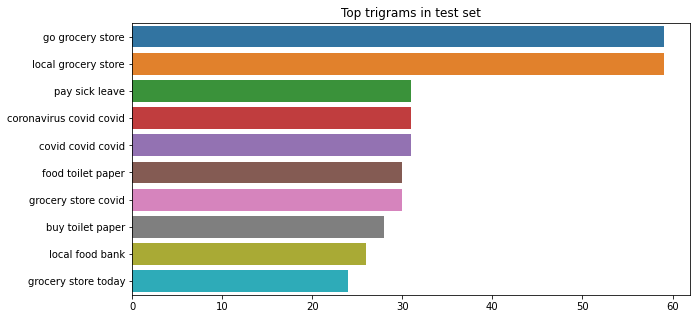

In [180]:
top_n_trigrams=get_top_ngram(test['test_cleaned'],3)
x,y=map(list,zip(*top_n_trigrams)) 
plt.figure(figsize=(10,5))
sns.barplot(x=y,y=x)
plt.title('Top trigrams in test set')

<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for review corpus'}, xlabel='POS', ylabel='count'>

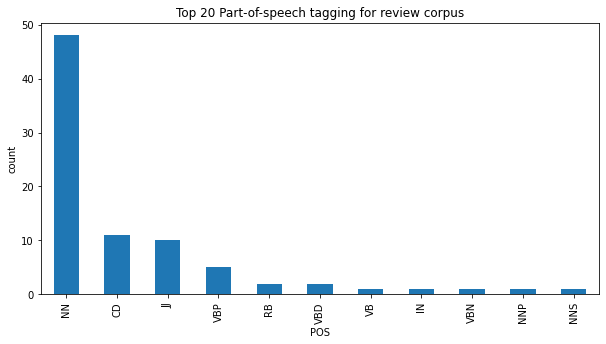

In [183]:
#most occured parts of speech in training set
blob = TextBlob(str(train['train_cleaned']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(10,5))
pos_df.plot(
    kind='bar',
    xlabel='POS',
    ylabel='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for tweets in test set'}, xlabel='POS', ylabel='count'>

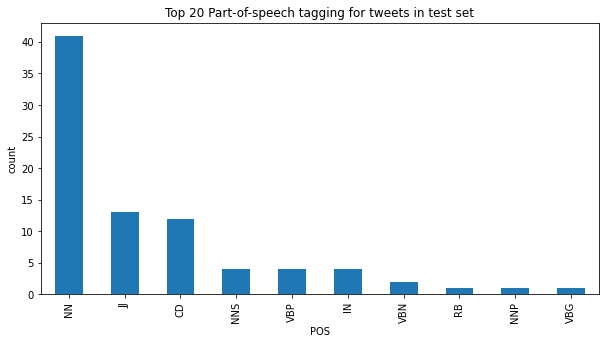

In [184]:
#most occured parts of speech in test set
blob = TextBlob(str(test['test_cleaned']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(10,5))
pos_df.plot(
    kind='bar',
    xlabel='POS',
    ylabel='count', 
    title='Top 20 Part-of-speech tagging for tweets in test set')

*Most of the words are singular nouns(NN) in both training and test sets.*

In [185]:
x1 = train.loc[train['Sentiment']=='Positive','Polarity_Score']
x2 = train.loc[train['Sentiment']=='Neutral','Polarity_Score']
x3 = train.loc[train['Sentiment']=='Negative','Polarity_Score']

trace1 = go.Histogram(
    x=x1, name='Positive',
    opacity=0.6
)
trace2 = go.Histogram(
    x=x2, name = 'Neutral',
    opacity=0.6
)
trace3 = go.Histogram(
    x=x3, name = 'Negative',
    opacity=0.3
)

data = [trace1, trace2, trace3]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity based on Tweet Sentiments',)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [186]:
x1 = test.loc[test['Sentiment']=='Positive','Polarity_Score']
x2 = test.loc[test['Sentiment']=='Neutral','Polarity_Score']
x3 = test.loc[test['Sentiment']=='Negative','Polarity_Score']

trace1 = go.Histogram(
    x=x1, name='Positive',
    opacity=0.3
)
trace2 = go.Histogram(
    x=x2, name = 'Neutral',
    opacity=0.3
)
trace3 = go.Histogram(
    x=x3, name = 'Negative',
    opacity=0.3
)

data = [trace1, trace2, trace3]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity based on Tweet Sentiments',)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

*Those tweets having polarity score low have neutral and negative tweets which are high in both training and test set.*

In [187]:
#separating positive,negative and neutral tweets from training set
positive=train[train['Sentiment']=='Positive']['train_cleaned']
negative=train[train['Sentiment']=='Negative']['train_cleaned']
neutral=train[train['Sentiment']=='Neutral']['train_cleaned']
training_sent=[positive,neutral,negative]

In [188]:
#separating positive,negative and neutral tweets from test set
positive_t=test[test['Sentiment']=='Positive']['test_cleaned']
negative_t=test[test['Sentiment']=='Negative']['test_cleaned']
neutral_t=test[test['Sentiment']=='Neutral']['test_cleaned']
test_sent=[positive_t,neutral_t,negative_t]

In [189]:
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate(' '.join(data))
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

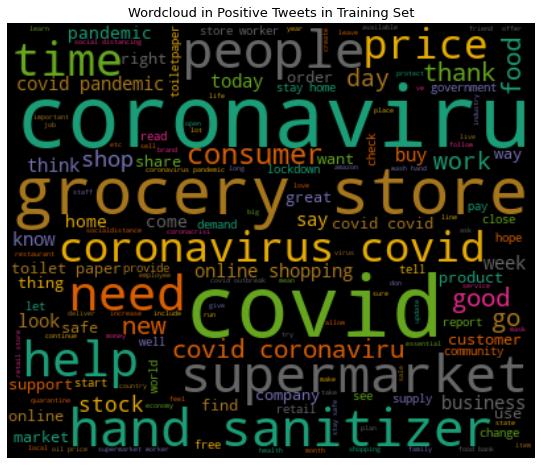

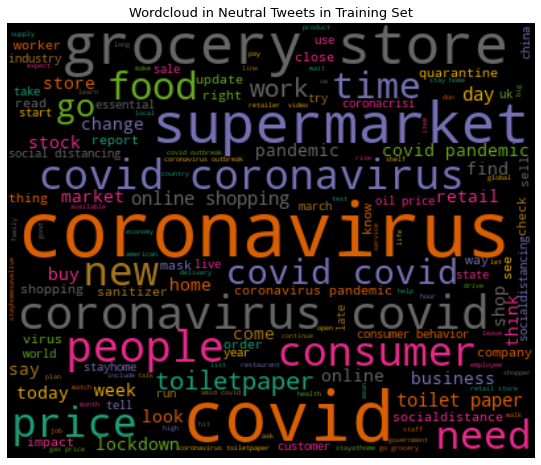

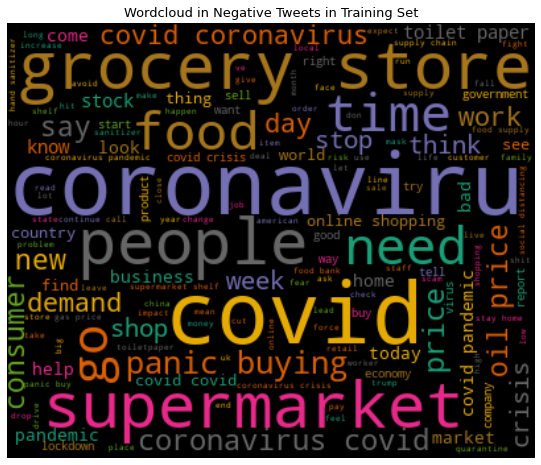

In [190]:
x=['Positive','Neutral','Negative']
for i in range(len(training_sent)):
    generate_wordcloud(training_sent[i],'Wordcloud in {i} Tweets in Training Set'.format(i=x[i]))

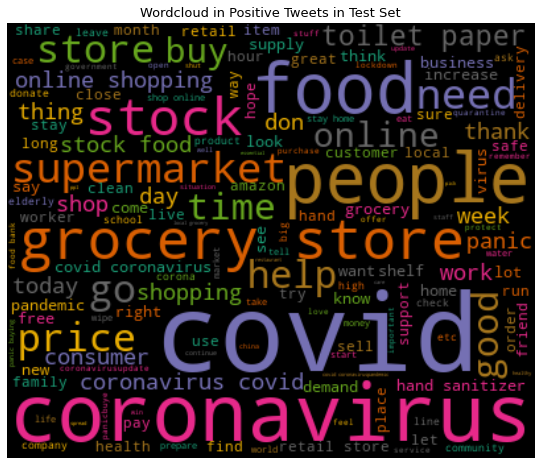

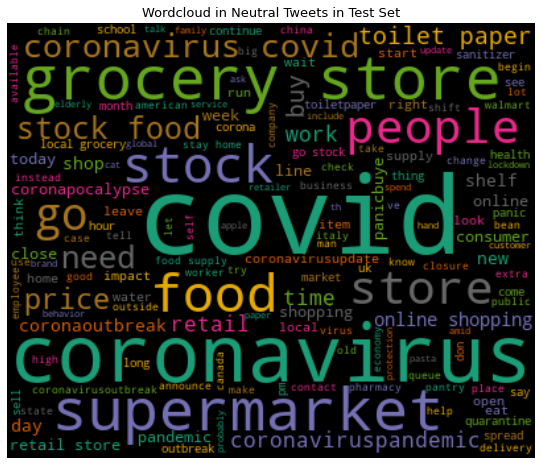

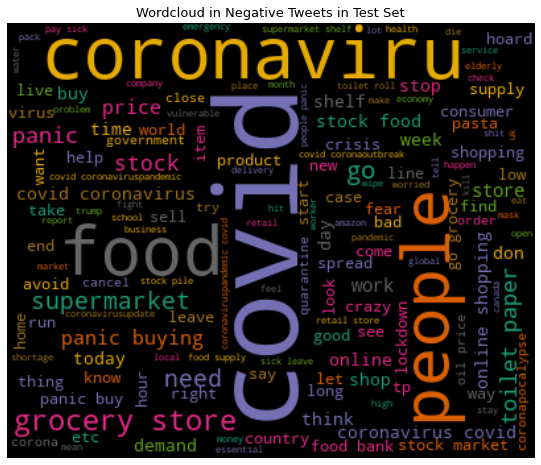

In [191]:
x=['Positive','Neutral','Negative']
for i in range(len(test_sent)):
    generate_wordcloud(test_sent[i],'Wordcloud in {i} Tweets in Test Set'.format(i=x[i]))

In [192]:
train_data=train.drop(columns=['Polarity_Score','Tweet'], axis=1)
test_data=test.drop(columns=['Polarity_Score','Tweet'], axis=1)

In [193]:
train_data.isnull().sum()

Sentiment        0
train_cleaned    0
dtype: int64

In [194]:
test_data.isnull().sum()

Sentiment       0
test_cleaned    0
dtype: int64

In [195]:
train_data.to_csv('train_data.csv',index=False)
test_data.to_csv('test_data.csv',index=False)